<a href="https://colab.research.google.com/github/Maya7991/gsc_classification/blob/main/net_with_attention%26bbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
class Net1(nn.Module):
    def __init__(self, keyword_list, emb_dim=512):
        super().__init__()
        self.vocab = {k: i for i, k in enumerate(keyword_list)}
        self.embedding = nn.Embedding(len(keyword_list), emb_dim)

    def forward(self, keyword: str):
        idx = torch.tensor([self.vocab[keyword]], dtype=torch.long)
        return self.embedding(idx).unsqueeze(1)  # (1, 1, 512)


In [31]:
class Net2CNN(nn.Module):
    def __init__(self, output_dim=512):
        super(Net2CNN, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])  # (B, 2048, 7, 7)
        self.proj = nn.Conv2d(2048, output_dim, kernel_size=1)  # Reduce channels

    def forward(self, x):
        x = self.feature_extractor(x)  # (B, 2048, 7, 7)
        x = self.proj(x)              # (B, output_dim, 7, 7)
        x = x.flatten(2).transpose(1, 2)  # (B, 49, output_dim)
        return x

In [32]:
class Net3(nn.Module):
    def __init__(self, dim=512):
        super(Net3, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)
        self.cls = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 1),
            nn.Sigmoid()
        )

    def forward(self, image_features, keyword_vector):
        output, _ = self.attn(query=keyword_vector, key=image_features, value=image_features)
        return self.cls(output).squeeze()  # → scalar probability


In [33]:
# Set up
keyword_list = ["hand", "cat", "car", "dog"]
net1 = Net1(keyword_list)
net2 = Net2CNN()
net3 = Net3()

# Load and preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

base_path = '/content/drive/My Drive/Colab Notebooks/'
image_path = f'{base_path}pup.jpg'
img = Image.open(image_path).convert("RGB")
# img = Image.new('RGB', (224, 224), color = 'black')
img_tensor = transform(img).unsqueeze(0)  # (1, 3, 224, 224)

# Inference
keyword = "dog"
kw_vec = net1(keyword)               # (1, 1, 512)
img_feat = net2(img_tensor)          # (1, 49, 512)
result = net3(img_feat, kw_vec)      # scalar

print(f"Probability of '{keyword}' in image: {result.item():.2f}")


Probability of 'dog' in image: 0.44


In [34]:
class Net3WithBox(nn.Module):
    def __init__(self, dim=512):
        super(Net3WithBox, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=4, batch_first=True)
        self.norm = nn.LayerNorm(dim)

        # Classifier: is the keyword in the image?
        self.classifier = nn.Sequential(
            nn.Linear(dim, 1),
            nn.Sigmoid()
        )

        # Bounding box regressor: predicts (x, y, w, h) normalized [0, 1]
        self.bbox_regressor = nn.Sequential(
            nn.Linear(dim, 4),
            nn.Sigmoid()
        )

    def forward(self, image_features, keyword_vector):
        attn_output, _ = self.attn(query=keyword_vector, key=image_features, value=image_features)
        x = self.norm(attn_output.squeeze(1))  # (B, dim)
        score = self.classifier(x)
        bbox = self.bbox_regressor(x)  # (B, 4) → normalized coordinates
        return score, bbox


In [35]:

def visualize_bbox(image, bbox, label, confidence):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    H, W = image.size[1], image.size[0]
    x, y, w, h = bbox
    x1, y1 = x * W, y * H
    w, h = w * W, h * H
    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 10, f'{label}: {confidence:.2f}', color='red', fontsize=12)
    plt.axis('off')
    plt.show()


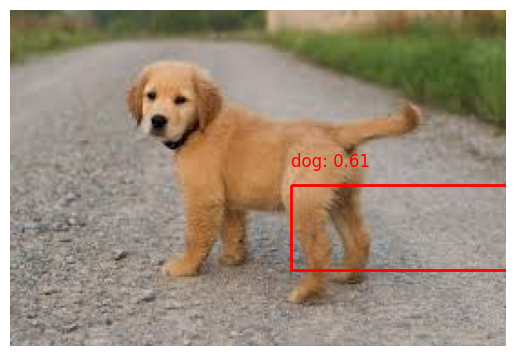

In [64]:
net3 = Net3WithBox()

# Forward pass
kw_vec = net1("dog")                  # (1, 1, 512)
img_feat = net2(img_tensor)            # (1, 49, 512)
score, bbox = net3(img_feat, kw_vec)   # (1,), (1, 4)

# Threshold and visualize
if score.item() > 0.5:
    visualize_bbox(img, bbox.squeeze().detach().cpu(), "dog", score.item())
else:
    print("No 'dog' detected.")
